In [1]:
#
import numpy as np
import xarray as xr
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import pandas as pd
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import cmaps
import matplotlib.ticker as ticker
from PyEMD import EEMD
from scipy.fft import fft, fftfreq
from scipy.integrate import simpson
from scipy.stats import pearsonr
import scipy
from scipy.stats import spearmanr
from scipy.signal import butter, filtfilt, convolve
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress
import seawater
import warnings
from scipy.ndimage import gaussian_filter
from scipy.stats import genextreme
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings('ignore')

def add_right_cax_big (ax0, ax3, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax3. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x1 + pad, #ax0 的右边 (x1) 加上 pad 的值
        axpos2.y0,
        axpos1.x1 + pad + width,#颜色条的宽度
        axpos1.y1
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_bottom_cax_big (ax0, ax3, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax3. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x0,
        axpos1.y0 - pad -width,
        axpos2.x1,
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_bottom_cax_big_right (ax0, ax7, pad, width, k) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax7. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos2.x1-k*(axpos2.x1-axpos1.x0),
        axpos1.y0 - pad -width,
        axpos2.x1,
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax
    
plt.rcParams['font.sans-serif']=['Helvetica']

/tmp/ipykernel_103087/1805665044.py:28: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:
def is_point_inside_polygon(point, polygon):
    point_obj = Point(point[0], point[1])
    return polygon.contains(point_obj) #不规则图形掩码

def Area_mask(data,lat0,lat1,lon0,lon1,Points):
    mask = data.copy()
    try:
        mask.loc[{'lat':slice(lat0,lat1),'lon':slice(lon0,lon1)}] = np.nan
    except KeyError:
        mask.loc[{'latitude':slice(lat0,lat1),'longitude':slice(lon0,lon1)}] = np.nan
    
    polygon = Polygon(Points)

    it = np.ndindex(np.squeeze(data[0].T).shape)
    for idx in it:
        lon_idx = idx[0]
        lat_idx = idx[1]
        try:
            lon = mask.lon[lon_idx]
            lat = mask.lat[lat_idx]
        except AttributeError:
            lon = mask.longitude[lon_idx]
            lat = mask.latitude[lat_idx]
        point = (lon,lat)
        if is_point_inside_polygon(point, polygon):
            mask[:,lat_idx, lon_idx] = np.nan
    return mask

def weight_mean(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        w = weight.copy()
        w[np.isnan(data[i])] = np.nan
        res[i] = np.nansum(data[i,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def weight_mean_4d(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            w = weight.copy()
            w[np.isnan(data[i,j,:,:])] = np.nan
            res[i,j] = np.nansum(data[i,j,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def linear_trend(data):
    slope = np.full_like(data[0],np.nan)
    p = np.full_like(data[0],np.nan)
    for i in range(np.shape(data)[1]):
        for j in range(np.shape(data)[2]):
            slope[i,j], _, _, p[i,j], _ = linregress(np.arange(len(data[:,i,j])),data[:,i,j])
    return slope, p

In [3]:
def Cal_mon_clim(data,n1,n2):
    data_bar = np.nanmean(np.reshape(np.array(data[n1:n2]),(30,12,np.shape(data)[1],np.shape(data)[2])),0)
    data_bar = np.tile(data_bar,(50,1,1))[:np.shape(data)[0]]
    data_prime = data - data_bar
    return data_bar, data_prime

def diag_period(data,t1,t2,mask,n,dx,dy):
    res = np.zeros(len(data)-1)
    for i in range(len(data)-1):
        res[i] = annual_integral_1(weight_mean(data[i]*mask,dx,dy),t1,t2)[n]
    res = np.append(res,res[0]-np.sum(res[1:]))
    res = np.insert(res,1,np.sum(res[1:4]))
    res = np.insert(res,5,np.sum(res[5:8]))
    res = np.insert(res,9,np.sum(res[9:12]))
    return res

def diag_period_daily(data,d1,d2,mask,dx,dy):
    res = np.zeros(len(data)-1)
    for i in range(len(data)-1):
        res[i] = np.sum(weight_mean(data[i]*mask,dx,dy)[d1:d2])*24*3600
    res = np.append(res,res[0]-np.sum(res[1:]))
    res = np.insert(res,1,np.sum(res[1:4]))
    res = np.insert(res,5,np.sum(res[5:8]))
    res = np.insert(res,9,np.sum(res[9:12]))
    return res

def annual_integral_1(data,n1,n2):
    res = np.zeros(int(len(data)/12))
    for i in range(int(len(data)/12)):
        res[i] = (simpson(data[12*i+n1-1:12*i+n2]))*30*24*3600
    return res

def annual_diff_1(data,n1,n2):
    res = np.zeros(int(len(data)/12))
    for i in range(int(len(data)/12)):
        res[i] = data[12*i+n2-1]-data[12*i+n1-1]
    return res


def sel_year(data,m1,m2):
    res = np.zeros((int(len(data)/12),np.shape(data)[1],np.shape(data)[2]))
    for i in range(int(len(data)/12)):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2],0)
    return res

def fit_uncert(x,y,k,d):
    y_pred = d + k * x
    t_crit = scipy.stats.t.ppf(1 - 0.05/2, len(x)-2)
    res  = y - y_pred
    x_fit = np.linspace(-6, 6, 200)
    y_fit = d + k * x_fit
    s_err = np.sqrt(np.sum(res**2) / (len(x)-2))
    SSxx   = np.sum((x - np.mean(x))**2)
    se_fit = s_err * np.sqrt(1/len(x) + (x_fit - np.mean(x))**2 / SSxx)
    ci     = t_crit * se_fit
    return x_fit, y_fit, ci

In [4]:
def OISST_series():
    fpath = '/2024data2/yangsl/Yangsl/OISST/OISST/OISST_1982-2024.nc'  # 你的海平面温度数据文件路径
    sst = xr.open_dataset(fpath)['sst'].sel(lon=slice(104, 131.5),lat=slice(0,42)).squeeze()
    sst = sst.sel(time=~((sst.time.dt.month == 2) & (sst.time.dt.day == 29)))
    Points_E = [(131.5, 31.2),(130.5, 30.4),(129.5, 28.3),(129, 27.7),(128, 26.6),(125.3, 24.75),(123.75, 24.3),(123, 23.9),(131.5, 23.9)]
    Points_S = [(120, 12),(119.5, 11),(118.5, 9.5),(117.5, 8.7),(117.2, 7.3),(117.2, 6),(121.5,6),(121.5,12)]
    sst_ES = Area_mask(sst,34.5,42,127,131.5,Points_E)
    sst_ES = Area_mask(sst_ES,0,6,117.2,122,Points_S)
    sst_ES = Area_mask(sst_ES,0,24,121.5,131.5,Points_S)
    mask_ES = np.ones_like(sst_ES[0])
    mask_ES[np.isnan(sst_ES[0])] = np.nan
    return sst, mask_ES

def oras5_diag(lon,lat):
    # 打开三维文件
    mld = xr.open_dataset('ORAS5/mld.nc')['somxl030'].interp(lon=lon,lat=lat)
    qnet = xr.open_dataset('ORAS5/qnet.nc')['sohefldo'].interp(lon=lon,lat=lat)
    tx = xr.open_dataset('ORAS5/taox.nc')['sozotaux'].interp(lon=lon,lat=lat)
    ty = xr.open_dataset('ORAS5/taoy.nc')['sometauy'].interp(lon=lon,lat=lat)
    # 打开四维文件
    u = xr.open_dataset('ORAS5/U.nc')['vozocrtx'].sel(depthu=slice(0,450)).interp(lon=lon,lat=lat)
    v = xr.open_dataset('ORAS5/V.nc')['vomecrty'].sel(depthv=slice(0,450)).interp(lon=lon,lat=lat)
    t = xr.open_dataset('ORAS5/T.nc')['votemper'].sel(deptht=slice(0,450)).interp(lon=lon,lat=lat)
    # 混合层平均和垂直速度计算
    depth = u.depthu.data
    u_mld = u.where(u.depthu <= mld, 0)
    v_mld = v.where(v.depthv <= mld, 0)
    t_mld = t.where(t.deptht <= mld, 0)
    u_mld = u_mld.fillna(0)
    v_mld = v_mld.fillna(0)
    t_mld = t_mld.fillna(0)

    depth_new = np.swapaxes(np.swapaxes(np.tile(depth,(528,168,110,1)),1,3),2,3)
    depth_new[t_mld==0] = 0
    depth_new = np.nanmax(depth_new,axis=1)
    depth_new[depth_new==0] = np.nan

    depth_b = np.swapaxes(np.swapaxes(np.tile(depth,(528,168,110,1)),1,3),2,3)
    depth_b[t_mld!=0] = np.nan
    depth_b = np.nanargmin(depth_b,axis=1)
    tb = t.isel(deptht=xr.DataArray(depth_b, dims=['time_counter', 'lat', 'lon']))
    ub = u.isel(depthu=xr.DataArray(depth_b, dims=['time_counter', 'lat', 'lon']))
    vb = v.isel(depthv=xr.DataArray(depth_b, dims=['time_counter', 'lat', 'lon']))
    u_mld = (np.sum(u_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((u_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    v_mld = (np.sum(v_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((v_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    t_mld = (np.sum(t_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((t_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values

    f = 2*7.292e-5*np.sin(np.radians(Lat))
    wh = np.gradient(ty/1026/f,axis=2)/dx-np.gradient(tx/1026/f,axis=1)/dy
    wmld = np.gradient(mld,axis=0)/30/24/3600+ub*np.gradient(mld,axis=2)/dx+vb*np.gradient(mld,axis=1)/dy
    we = wh+wmld
    # 分离时间尺度
    mld_bar,mld_prime = Cal_mon_clim(mld,120,480)
    qnet_bar,qnet_prime = Cal_mon_clim(qnet,120,480)
    u_bar,u_prime = Cal_mon_clim(u_mld,120,480)
    v_bar,v_prime = Cal_mon_clim(v_mld,120,480)
    t_bar,t_prime = Cal_mon_clim(t_mld,120,480)
    tb_bar,tb_prime = Cal_mon_clim(tb,120,480)
    we_bar,we_prime = Cal_mon_clim(we,120,480)
    wh_bar,wh_prime = Cal_mon_clim(wh,120,480)
    wmld_bar,wmld_prime = Cal_mon_clim(wmld,120,480)
    # 混合层热收支 Part1
    dt_prime = np.gradient(t_prime,axis=0)/30/24/3600

    flux_Q = qnet_prime/mld_bar/1026/4187
    flux_H = -mld_prime*qnet_bar/mld_bar/mld_bar/1026/4187
    flux_NL = -mld_prime*qnet_prime/mld_bar/mld_bar/1026/4187+np.mean(mld_prime*qnet_prime/mld_bar/mld_bar/1026/4187,0)
    flux_ALL = qnet/mld/1026/4187 - qnet_bar/mld_bar/1026/4187
    # 混合层热收支 Part2
    adv_pp = -u_prime*np.gradient(t_prime,axis=2)/dx-v_prime*np.gradient(t_prime,axis=1)/dy + np.mean(u_prime*np.gradient(t_prime,axis=2)/dx+v_prime*np.gradient(t_prime,axis=1)/dy,0)
    adv_pp[(~np.isnan(t_mld))&np.isnan(adv_pp)] = 0
    adv_bp = -u_bar*np.gradient(t_prime,axis=2)/dx-v_bar*np.gradient(t_prime,axis=1)/dy
    adv_bp[(~np.isnan(t_mld))&np.isnan(adv_bp)] = 0
    adv_pb = -u_prime*np.gradient(t_bar,axis=2)/dx-v_prime*np.gradient(t_bar,axis=1)/dy
    adv_pb[(~np.isnan(t_mld))&np.isnan(adv_pb)] = 0
    # 混合层热收支 Part3
    H = np.zeros_like(we_bar)
    H[we_bar>0] = 1
    en_pp = np.array(-H*we_prime*(t_prime-tb_prime)/mld+np.mean(H*we_prime*(t_prime-tb_prime)/mld,0))
    en_pp[(~np.isnan(t_mld))&np.isnan(en_pp)] = 0
    en_bp = np.array(-H*we_bar*(t_prime-tb_prime)/mld)
    en_bp[(~np.isnan(t_mld))&np.isnan(en_bp)] = 0
    en_pb = np.array(-H*we_prime*(t_bar-tb_bar)/mld)
    en_pb[(~np.isnan(t_mld))&np.isnan(en_pb)] = 0

    en_pb_h = np.array(-H*wh_prime*(t_bar-tb_bar)/mld)
    en_pb_h[(~np.isnan(t_mld))&np.isnan(en_pb_h)] = 0
    en_pb_mld = np.array(-H*wmld_prime*(t_bar-tb_bar)/mld)
    en_pb_mld[(~np.isnan(t_mld))&np.isnan(en_pb_mld)] = 0
    return dt_prime,flux_Q,flux_H,flux_NL,adv_pp,adv_bp,adv_pb,en_pb,en_bp,en_pp, flux_ALL

def hycom_diag(Lon,Lat):
    # 打开三维文件
    mld = xr.open_dataset('HYCOM/HYCOM_2d.nc')['mixed_layer_thickness'][12:]
    qnet = xr.open_dataset('HYCOM/HYCOM_2d.nc')['qtot'][12:]
    # 打开三维文件
    u = xr.open_dataset('HYCOM/HYCOM_3z.nc')['u'][12:]
    v = xr.open_dataset('HYCOM/HYCOM_3z.nc')['v'][12:]
    w = xr.open_dataset('HYCOM/HYCOM_3z.nc')['w_velocity'][12:]
    t = xr.open_dataset('HYCOM/HYCOM_3z.nc')['pot_temp'][12:]
    mLon, mLat = np.meshgrid(mld.Longitude.data, mld.Latitude.data)
    mdx = 6371*1e3*np.pi/180*np.gradient(mLon,axis=1)*np.cos(np.radians(mLat))
    mdy = 6371*1e3*np.pi/180*np.gradient(mLat,axis=0)
    # 混合层平均和垂直速度计算
    depth = u.Depth.data
    u_mld = u.where(u.Depth <= mld, 0)
    v_mld = v.where(v.Depth <= mld, 0)
    t_mld = t.where(t.Depth <= mld, 0)
    u_mld = u_mld.fillna(0)
    v_mld = v_mld.fillna(0)
    t_mld = t_mld.fillna(0)

    depth_new = np.swapaxes(np.swapaxes(np.tile(depth,(408, 246, 176, 1)),1,3),2,3)
    depth_new[t_mld==0] = 0
    depth_new = np.nanmax(depth_new,axis=1)
    depth_new[depth_new==0] = np.nan

    depth_b = np.swapaxes(np.swapaxes(np.tile(depth,(408, 246, 176, 1)),1,3),2,3)
    depth_b[t_mld!=0] = np.nan
    depth_b = np.nanargmin(depth_b,axis=1)
    tb = t.isel(Depth=xr.DataArray(depth_b, dims=['MT', 'Latitude', 'Longitude']))
    wh = w.isel(Depth=xr.DataArray(depth_b, dims=['MT', 'Latitude', 'Longitude']))
    ub = u.isel(Depth=xr.DataArray(depth_b, dims=['MT', 'Latitude', 'Longitude']))
    vb = v.isel(Depth=xr.DataArray(depth_b, dims=['MT', 'Latitude', 'Longitude']))
    u_mld = (np.sum(u_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((u_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    v_mld = (np.sum(v_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((v_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    t_mld = (np.sum(t_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((t_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    wmld = np.gradient(mld,axis=0)/30/24/3600+ub*np.gradient(mld,axis=2)/mdx+vb*np.gradient(mld,axis=1)/mdy
    we = wh+wmld
    # 分离时间尺度
    mld_bar,mld_prime = Cal_mon_clim(mld,0,360)
    qnet_bar,qnet_prime = Cal_mon_clim(qnet,0,360)
    u_bar,u_prime = Cal_mon_clim(u_mld,0,360)
    v_bar,v_prime = Cal_mon_clim(v_mld,0,360)
    t_bar,t_prime = Cal_mon_clim(t_mld,0,360)
    tb_bar,tb_prime = Cal_mon_clim(tb,0,360)
    we_bar,we_prime = Cal_mon_clim(we,0,360)
    wh_bar,wh_prime = Cal_mon_clim(wh,0,360)
    wmld_bar,wmld_prime = Cal_mon_clim(wmld,0,360)
    # 混合层热收支 Part1
    dt_prime = np.gradient(t_prime,axis=0)/30/24/3600

    flux_Q = qnet_prime/mld_bar/1026/4187
    flux_H = -mld_prime*qnet_bar/mld_bar/mld_bar/1026/4187
    flux_NL = -mld_prime*qnet_prime/mld_bar/mld_bar/1026/4187+np.mean(mld_prime*qnet_prime/mld_bar/mld_bar/1026/4187,0)
    flux_ALL = qnet/mld/1026/4187 - qnet_bar/mld_bar/1026/4187
    # 混合层热收支 Part2
    adv_pp = -u_prime*np.gradient(t_prime,axis=2)/mdx-v_prime*np.gradient(t_prime,axis=1)/mdy + np.mean(u_prime*np.gradient(t_prime,axis=2)/mdx+v_prime*np.gradient(t_prime,axis=1)/mdy,0)
    adv_pp[(~np.isnan(t_mld))&np.isnan(adv_pp)] = 0
    adv_bp = -u_bar*np.gradient(t_prime,axis=2)/mdx-v_bar*np.gradient(t_prime,axis=1)/mdy
    adv_bp[(~np.isnan(t_mld))&np.isnan(adv_bp)] = 0
    adv_pb = -u_prime*np.gradient(t_bar,axis=2)/mdx-v_prime*np.gradient(t_bar,axis=1)/mdy
    adv_pb[(~np.isnan(t_mld))&np.isnan(adv_pb)] = 0
    # 混合层热收支 Part3
    H = np.zeros_like(we_bar)
    H[we_bar>0] = 1
    en_pp = np.array(-H*we_prime*(t_prime-tb_prime)/mld+np.mean(H*we_prime*(t_prime-tb_prime)/mld,0))
    en_pp[(~np.isnan(t_mld))&np.isnan(en_pp)] = 0
    en_bp = np.array(-H*we_bar*(t_prime-tb_prime)/mld)
    en_bp[(~np.isnan(t_mld))&np.isnan(en_bp)] = 0
    en_pb = np.array(-H*we_prime*(t_bar-tb_bar)/mld)
    en_pb[(~np.isnan(t_mld))&np.isnan(en_pb)] = 0

    en_pb_h = np.array(-H*wh_prime*(t_bar-tb_bar)/mld)
    en_pb_h[(~np.isnan(t_mld))&np.isnan(en_pb_h)] = 0
    en_pb_mld = np.array(-H*wmld_prime*(t_bar-tb_bar)/mld)
    en_pb_mld[(~np.isnan(t_mld))&np.isnan(en_pb_mld)] = 0
    dt_prime_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), dt_prime[i], bounds_error=False, fill_value=np.nan)
        dt_prime_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    dt_prime = dt_prime_25

    flux_ALL_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), flux_ALL.data[i], bounds_error=False, fill_value=np.nan)
        flux_ALL_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    flux_ALL = flux_ALL_25

    flux_Q_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), flux_Q.values[i], bounds_error=False, fill_value=np.nan)
        flux_Q_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    flux_Q = flux_Q_25
    flux_H_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), flux_H.values[i], bounds_error=False, fill_value=np.nan)
        flux_H_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    flux_H = flux_H_25
    flux_NL_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), flux_NL.values[i], bounds_error=False, fill_value=np.nan)
        flux_NL_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    flux_NL = flux_NL_25
    adv_pp_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), adv_pp[i], bounds_error=False, fill_value=np.nan)
        adv_pp_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    adv_pp = adv_pp_25
    adv_bp_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), adv_bp[i], bounds_error=False, fill_value=np.nan)
        adv_bp_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    adv_bp = adv_bp_25
    adv_pb_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), adv_pb[i], bounds_error=False, fill_value=np.nan)
        adv_pb_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    adv_pb = adv_pb_25
    en_pp_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), en_pp[i], bounds_error=False, fill_value=np.nan)
        en_pp_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    en_pp = en_pp_25
    en_bp_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), en_bp[i], bounds_error=False, fill_value=np.nan)
        en_bp_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    en_bp = en_bp_25
    en_pb_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), en_pb[i], bounds_error=False, fill_value=np.nan)
        en_pb_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    en_pb = en_pb_25

    en_pb_h_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), en_pb_h[i], bounds_error=False, fill_value=np.nan)
        en_pb_h_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    en_pb_h = en_pb_h_25

    en_pb_mld_25 = np.full((408,168,110),np.nan)
    for i in range(408):
        interp = RegularGridInterpolator((mld.Latitude,mld.Longitude), en_pb_mld[i], bounds_error=False, fill_value=np.nan)
        en_pb_mld_25[i] = interp(np.stack((Lat.ravel(), Lon.ravel()), axis=-1)).reshape(168, 110)
    en_pb_mld = en_pb_mld_25
    return dt_prime,flux_Q,flux_H,flux_NL,adv_pp,adv_bp,adv_pb,en_pb,en_bp,en_pp, flux_ALL

def m2d_bar(lon,lat):
    da = xr.open_dataset('./ERA5/clim_daily/sw/sw_clim.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    sw = da['avg_snswrf'].data

    da = xr.open_dataset('./ERA5/clim_daily/lw/lw_clim.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    lw = da['avg_snlwrf'].data

    da = xr.open_dataset('./ERA5/clim_daily/lhf/lhf_clim.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    lhf = da['avg_slhtf'].data

    da = xr.open_dataset('./ERA5/clim_daily/shf/shf_clim.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    shf = da['avg_ishf'].data

    da = xr.open_dataset('./ERA5/clim_daily/u10/u10_clim.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    da1 = xr.open_dataset('./ERA5/clim_daily/v10/v10_clim.nc').interp(longitude=lon,latitude=lat)
    da1 = da1.sel(valid_time=~((da1.valid_time.dt.month == 2) & (da1.valid_time.dt.day == 29)))
    tx = 1.225*1.3e-3*np.sqrt(da.u10.data**2 + da1.v10.data**2)*da.u10.data
    ty = 1.225*1.3e-3*np.sqrt(da.u10.data**2 + da1.v10.data**2)*da1.v10.data
    return sw, lw, lhf, shf, tx, ty

def daily_val(lon,lat):
    da = xr.open_dataset('./ERA5/daily/sw.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    sw = da['avg_snswrf'].data

    da = xr.open_dataset('./ERA5/daily/lw.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    lw = da['avg_snlwrf'].data

    da = xr.open_dataset('./ERA5/daily/lhf.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    lhf = da['avg_slhtf'].data

    da = xr.open_dataset('./ERA5/daily/shf.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    shf = da['avg_ishf'].data

    da = xr.open_dataset('./ERA5/daily/u10.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(valid_time=~((da.valid_time.dt.month == 2) & (da.valid_time.dt.day == 29)))
    da1 = xr.open_dataset('./ERA5/daily/v10.nc').interp(longitude=lon,latitude=lat)
    da1 = da1.sel(valid_time=~((da1.valid_time.dt.month == 2) & (da1.valid_time.dt.day == 29)))
    tx = 1.225*1.3e-3*np.sqrt(da.u10.data**2 + da1.v10.data**2)*da.u10.data
    ty = 1.225*1.3e-3*np.sqrt(da.u10.data**2 + da1.v10.data**2)*da1.v10.data
    return sw, lw, lhf, shf, tx, ty

def daily_ocn(lon,lat):
    da = xr.open_dataset('./GLORYS/GLORYS12V1.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(time=~((da.time.dt.month == 2) & (da.time.dt.day == 29)))
    t = da.thetao
    mld = da.mlotst
    u = da.uo
    v = da.vo
    u_mld = u.where(da.depth <= mld, 0)
    v_mld = v.where(da.depth <= mld, 0)
    t_mld = t.where(da.depth <= mld, 0)
    u_mld = u_mld.fillna(0)
    v_mld = v_mld.fillna(0)
    t_mld = t_mld.fillna(0)
    depth = da.depth.data
    depth_new = np.swapaxes(np.swapaxes(np.tile(depth,(365, 168, 110, 1)),1,3),2,3)
    depth_new[t_mld==0] = 0
    depth_new = np.nanmax(depth_new,axis=1)
    depth_new[depth_new==0] = np.nan
    depth_b = np.swapaxes(np.swapaxes(np.tile(depth,(365, 168, 110, 1)),1,3),2,3)
    depth_b[t_mld!=0] = np.nan
    depth_b = np.nanargmin(depth_b,axis=1)
    tb = t.isel(depth=xr.DataArray(depth_b, dims=['time', 'latitude', 'longitude']))
    ub = u.isel(depth=xr.DataArray(depth_b, dims=['time', 'latitude', 'longitude']))
    vb = v.isel(depth=xr.DataArray(depth_b, dims=['time', 'latitude', 'longitude']))
    u_mld = (np.sum(u_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((u_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    v_mld = (np.sum(v_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((v_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    t_mld = (np.sum(t_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((t_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    return t_mld, tb.data, mld.data, u_mld, ub.data, v_mld, vb.data, depth

def m2d_bar_ocn(lon,lat):
    da = xr.open_dataset('./GLORYS/GLORYS_clim_dailymean.nc').interp(longitude=lon,latitude=lat)
    da = da.sel(time=~((da.time.dt.month == 2) & (da.time.dt.day == 29)))
    t = da.thetao
    mld = da.mlotst
    u = da.uo
    v = da.vo
    u_mld = u.where(da.depth <= mld, 0)
    v_mld = v.where(da.depth <= mld, 0)
    t_mld = t.where(da.depth <= mld, 0)
    u_mld = u_mld.fillna(0)
    v_mld = v_mld.fillna(0)
    t_mld = t_mld.fillna(0)
    depth = da.depth.data
    depth_new = np.swapaxes(np.swapaxes(np.tile(depth,(365, 168, 110, 1)),1,3),2,3)
    depth_new[t_mld==0] = 0
    depth_new = np.nanmax(depth_new,axis=1)
    depth_new[depth_new==0] = np.nan
    depth_b = np.swapaxes(np.swapaxes(np.tile(depth,(365, 168, 110, 1)),1,3),2,3)
    depth_b[t_mld!=0] = np.nan
    depth_b = np.nanargmin(depth_b,axis=1)
    tb = t.isel(depth=xr.DataArray(depth_b, dims=['time', 'latitude', 'longitude']))
    ub = u.isel(depth=xr.DataArray(depth_b, dims=['time', 'latitude', 'longitude']))
    vb = v.isel(depth=xr.DataArray(depth_b, dims=['time', 'latitude', 'longitude']))
    u_mld = (np.sum(u_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((u_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    v_mld = (np.sum(v_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((v_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    t_mld = (np.sum(t_mld*np.gradient(depth)[None,:,None,None],axis=1)/np.sum((t_mld!=0)*np.gradient(depth)[None,:,None,None],axis=1)).values
    return t_mld, tb.data, mld.data, u_mld, ub.data, v_mld, vb.data
    
def daily_diag(lon,lat):
    sw_b, lw_b, lhf_b, shf_b, tx_b, ty_b = m2d_bar(lon,lat)
    sw, lw, lhf, shf, tx, ty = daily_val(lon,lat)
    t_mld, tb, mld, u_mld, ub, v_mld, vb, depth = daily_ocn(lon,lat)
    t_mld_b, tb_b, mld_b, u_mld_b, ub_b, v_mld_b, vb_b = m2d_bar_ocn(lon,lat)
    sw_p = sw - sw_b
    lw_p = lw - lw_b
    lhf_p = lhf - lhf_b
    shf_p = shf - shf_b
    tx_p = tx - tx_b
    ty_p = ty - ty_b
    t_mld_p = t_mld - t_mld_b
    u_mld_p = u_mld - u_mld_b
    v_mld_p = v_mld - v_mld_b
    mld_p = mld - mld_b
    tb_p = tb - tb_b
    ub_p = ub - ub_b
    vb_p = vb - vb_b
    qnet_p = sw_p + lw_p + lhf_p + shf_p
    qnet_b = sw_b + lw_b + lhf_b + shf_b
    qnet = sw + lw + lhf + shf

    f = 2*7.292e-5*np.sin(np.radians(Lat))
    wh = np.gradient(ty/1026/f,axis=2)/dx-np.gradient(tx/1026/f,axis=1)/dy
    wmld = np.gradient(mld,axis=0)/30/24/3600+ub*np.gradient(mld,axis=2)/dx+vb*np.gradient(mld,axis=1)/dy
    we = wh+wmld

    wh_b = np.gradient(ty_b/1026/f,axis=2)/dx-np.gradient(tx_b/1026/f,axis=1)/dy
    wmld_b = np.gradient(mld_b,axis=0)/30/24/3600+ub_b*np.gradient(mld_b,axis=2)/dx+vb_b*np.gradient(mld_b,axis=1)/dy
    we_b = wh_b+wmld_b

    we_p = we - we_b
    wh_p = wh - wh_b
    wmld_p = wmld - wmld_b
    # 混合层热收支 Part1
    dt_prime = np.gradient(t_mld_p,axis=0)/24/3600

    flux_Q = qnet_p/mld_b/1026/4187
    flux_SW = sw_p/mld_b/1026/4187
    flux_LW = lw_p/mld_b/1026/4187
    flux_LHF = lhf_p/mld_b/1026/4187
    flux_SHF = shf_p/mld_b/1026/4187
    flux_H = -mld_p*qnet_b/mld_b/mld_b/1026/4187
    flux_NL = -mld_p*qnet_p/mld_b/mld_b/1026/4187+np.mean(mld_p*qnet_p/mld_b/mld_b/1026/4187,0)
    flux_ALL = qnet/mld/1026/4187 - qnet_b/mld_b/1026/4187
    # 混合层热收支 Part2
    adv_pp = -u_mld_p*np.gradient(t_mld_p,axis=2)/dx-v_mld_p*np.gradient(t_mld_p,axis=1)/dy + np.mean(u_mld_p*np.gradient(t_mld_p,axis=2)/dx+v_mld_p*np.gradient(t_mld_p,axis=1)/dy,0)
    adv_pp[(~np.isnan(t_mld))&np.isnan(adv_pp)] = 0
    adv_bp = -u_mld_b*np.gradient(t_mld_p,axis=2)/dx-v_mld_b*np.gradient(t_mld_p,axis=1)/dy
    adv_bp[(~np.isnan(t_mld))&np.isnan(adv_bp)] = 0
    adv_pb = -u_mld_p*np.gradient(t_mld_b,axis=2)/dx-v_mld_p*np.gradient(t_mld_b,axis=1)/dy
    adv_pb[(~np.isnan(t_mld))&np.isnan(adv_pb)] = 0

    # 混合层热收支 Part3
    H = np.zeros_like(we_b)
    H[we_b>0] = 1
    en_pp = np.array(-H*we_p*(t_mld_p-tb_p)/mld+np.mean(H*we_p*(t_mld_p-tb_p)/mld,0))
    en_pp[(~np.isnan(t_mld))&np.isnan(en_pp)] = 0
    en_bp = np.array(-H*we_b*(t_mld_p-tb_p)/mld)
    en_bp[(~np.isnan(t_mld))&np.isnan(en_bp)] = 0
    en_pb = np.array(-H*we_p*(t_mld_b-tb_b)/mld)
    en_pb[(~np.isnan(t_mld))&np.isnan(en_pb)] = 0

    en_pb_h = np.array(-H*wh_p*(t_mld_b-tb_b)/mld)
    en_pb_h[(~np.isnan(t_mld))&np.isnan(en_pb_h)] = 0
    en_pb_mld = np.array(-H*wmld_p*(t_mld_b-tb_b)/mld)
    en_pb_mld[(~np.isnan(t_mld))&np.isnan(en_pb_mld)] = 0
    return dt_prime,flux_Q,flux_H,flux_NL,adv_pp,adv_bp,adv_pb,en_pb,en_bp,en_pp,flux_ALL,flux_SW,flux_LW,flux_LHF,flux_SHF

In [5]:
# 温度提取
sst_ES_oisst, mask_ES_oisst = OISST_series()
# 时间和经纬度
date = pd.date_range('2023-01-01', '2023-12-31', freq='D')
date_year_oisst = pd.date_range('1982-01-01', '2024-12-31', freq='YE')
date_month_oisst = pd.date_range('1982-01-01', '2024-12-31', freq='ME')
Lon, Lat = np.meshgrid(sst_ES_oisst.lon, sst_ES_oisst.lat)
dx = 6371*1e3*np.pi/180*np.gradient(Lon,axis=1)*np.cos(np.radians(Lat))
dy = 6371*1e3*np.pi/180*np.gradient(Lat,axis=0)
# 中国近海全部海域平均温度
sst_all = weight_mean(sst_ES_oisst*mask_ES_oisst,dx,dy)
base_all = np.mean(np.reshape(sst_all[9*365:39*365],(30,365)),0)
std_all = np.std(np.reshape(sst_all[9*365:39*365],(30,365)),0,ddof=1)
# 获取8-9月数据和高温掩膜
sst_ES_oisst_89 = sst_ES_oisst.sel(time=((sst_ES_oisst["time.month"] == 8) | (sst_ES_oisst["time.month"] == 9)))
base_ES_89 = np.mean(sst_ES_oisst_89.sel(time=((sst_ES_oisst_89["time.year"] < 2021) & (sst_ES_oisst_89["time.year"] > 1990))),0)
std_ES_89 = np.std(sst_ES_oisst_89.sel(time=((sst_ES_oisst_89["time.year"] < 2021) & (sst_ES_oisst_89["time.year"] > 1990))).groupby("time.year").mean(dim="time"),0)
year_ES_89 = sst_ES_oisst_89.resample(time='YE').mean()

mask_max = np.full_like(year_ES_89[0],np.nan)
mask_max[np.where(np.max(year_ES_89[:-1],0) <= year_ES_89[-1])] = 1
mask_hightemp = np.full_like(year_ES_89[0],np.nan)
mask_hightemp[(np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89)/std_ES_89>3] = 1
mask_hightemp[np.isnan(mask_ES_oisst)] = np.nan

sst_high = weight_mean(sst_ES_oisst*mask_hightemp,dx,dy)
base_high = np.mean(np.reshape(sst_high[9*365:39*365],(30,365)),0)
std_high = np.std(np.reshape(sst_high[9*365:39*365],(30,365)),0)
year_high_89 = weight_mean(year_ES_89*mask_hightemp,dx,dy)
year_ES = sst_ES_oisst.resample(time='YE').mean()
year_high = weight_mean(year_ES*mask_hightemp,dx,dy)

# 其他掩膜
mask_land = np.full_like(mask_hightemp,np.nan)
mask_land[np.isnan(sst_ES_oisst[0])] = 1

In [6]:
dt_prime_hycom,flux_Q_hycom, flux_H_hycom, flux_NL_hycom, adv_pp_hycom, adv_bp_hycom, adv_pb_hycom, en_pb_hycom, en_bp_hycom, en_pp_hycom, flux_ALL_hycom = hycom_diag(Lon,Lat)
dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pp_oras5,adv_bp_oras5,adv_pb_oras5,en_pb_oras5,en_bp_oras5,en_pp_oras5,flux_ALL_oras5 = oras5_diag(sst_ES_oisst.lon.data, sst_ES_oisst.lat.data)
dt_prime_daily,flux_Q_daily,flux_H_daily,flux_NL_daily,adv_pp_daily,adv_bp_daily,adv_pb_daily,en_pb_daily,en_bp_daily,en_pp_daily,flux_ALL_daily,flux_SW_daily,flux_LW_daily,flux_LHF_daily,flux_SHF_daily = daily_diag(sst_ES_oisst.lon.data, sst_ES_oisst.lat.data)

In [105]:
def timemean_diag(diag_list,mask,t1,t2):
    res = []
    for i in range(len(diag_list)):
        res.append(np.mean(weight_mean(diag_list[i]*mask,dx,dy)[t1:t2]))
    return res

In [ ]:
mask_YS = np.full_like(mask_hightemp,np.nan)
mask_YS[((0.3*Lon-Lat)<4.5)&(Lon<127)] =1
mask_YS[np.isnan(mask_hightemp)] = np.nan

mask_ECS = np.full_like(mask_hightemp,np.nan)
mask_ECS[~np.isnan(mask_hightemp)&np.isnan(mask_YS)] = 1

In [153]:
diag_oras5_clim = timemean_diag([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,
        en_pb_oras5,en_bp_oras5,en_pp_oras5],mask_hightemp,120,480)
diag_oras5_near = timemean_diag([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,
        en_pb_oras5,en_bp_oras5,en_pp_oras5],mask_hightemp,-120,None)

In [154]:
diag_oras5_clim_YS = timemean_diag([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,
        en_pb_oras5,en_bp_oras5,en_pp_oras5],mask_YS,120,480)
diag_oras5_near_YS = timemean_diag([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,
        en_pb_oras5,en_bp_oras5,en_pp_oras5],mask_YS,-120,None)
diag_oras5_clim_ECS = timemean_diag([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,
        en_pb_oras5,en_bp_oras5,en_pp_oras5],mask_ECS,120,480)
diag_oras5_near_ECS = timemean_diag([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,
        en_pb_oras5,en_bp_oras5,en_pp_oras5],mask_ECS,-120,None)

In [116]:
p2024_high_hycom = diag_period([dt_prime_hycom, flux_Q_hycom, flux_H_hycom, flux_NL_hycom, adv_pb_hycom, adv_bp_hycom, adv_pp_hycom, en_pb_hycom, en_bp_hycom, en_pp_hycom,flux_ALL_hycom],
            7,9,mask_hightemp,33,dx,dy)
p2024_high_oras5 = diag_period([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,en_pb_oras5,en_bp_oras5,en_pp_oras5,flux_ALL_oras5],
            7,9,mask_hightemp,43,dx,dy)
p2024_high_daily = diag_period_daily([dt_prime_daily,flux_Q_daily,flux_H_daily,flux_NL_daily,adv_pb_daily,adv_bp_daily,adv_pp_daily,en_pb_daily,en_bp_daily,en_pp_daily,flux_ALL_daily],
            208,262,mask_hightemp,dx,dy)
p2024_high = np.concatenate((p2024_high_daily[None,:],p2024_high_oras5[None,:],p2024_high_hycom[None,:]),axis=0)

In [117]:
p2024_high_hycom_8 = diag_period([dt_prime_hycom, flux_Q_hycom, flux_H_hycom, flux_NL_hycom, adv_pb_hycom, adv_bp_hycom, adv_pp_hycom, en_pb_hycom, en_bp_hycom, en_pp_hycom,flux_ALL_hycom],
            7,8,mask_hightemp,33,dx,dy)
p2024_high_oras5_8 = diag_period([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,en_pb_oras5,en_bp_oras5,en_pp_oras5,flux_ALL_oras5],
            7,8,mask_hightemp,43,dx,dy)
p2024_high_daily_8 = diag_period_daily([dt_prime_daily,flux_Q_daily,flux_H_daily,flux_NL_daily,adv_pb_daily,adv_bp_daily,adv_pp_daily,en_pb_daily,en_bp_daily,en_pp_daily,flux_ALL_daily],
            208,240,mask_hightemp,dx,dy)
p2024_high_8 = np.concatenate((p2024_high_daily_8[None,:],p2024_high_oras5_8[None,:],p2024_high_hycom_8[None,:]),axis=0)

In [118]:
p2024_high_hycom_9 = diag_period([dt_prime_hycom, flux_Q_hycom, flux_H_hycom, flux_NL_hycom, adv_pb_hycom, adv_bp_hycom, adv_pp_hycom, en_pb_hycom, en_bp_hycom, en_pp_hycom,flux_ALL_hycom],
            8,9,mask_hightemp,33,dx,dy)
p2024_high_oras5_9 = diag_period([dt_prime_oras5,flux_Q_oras5,flux_H_oras5,flux_NL_oras5,adv_pb_oras5,adv_bp_oras5,adv_pp_oras5,en_pb_oras5,en_bp_oras5,en_pp_oras5,flux_ALL_oras5],
            8,9,mask_hightemp,43,dx,dy)
p2024_high_daily_9 = diag_period_daily([dt_prime_daily,flux_Q_daily,flux_H_daily,flux_NL_daily,adv_pb_daily,adv_bp_daily,adv_pp_daily,en_pb_daily,en_bp_daily,en_pp_daily,flux_ALL_daily],
            240,262,mask_hightemp,dx,dy)
p2024_high_9 = np.concatenate((p2024_high_daily_9[None,:],p2024_high_oras5_9[None,:],p2024_high_hycom_9[None,:]),axis=0)

In [180]:
# hightemp短期增暖诊断
dt_high_s = annual_integral_1(weight_mean(dt_prime_oras5*mask_hightemp,dx,dy),7,9)
budget_high_s = annual_integral_1(weight_mean((flux_Q_oras5+flux_H_oras5+adv_bp_oras5+adv_pb_oras5+en_pb_oras5+en_bp_oras5)*mask_hightemp,dx,dy),7,9)

flux_high_s = annual_integral_1(weight_mean((flux_Q_oras5)*mask_hightemp,dx,dy),7,9)
ocn_high_s = annual_integral_1(weight_mean((flux_H_oras5+en_pb_oras5+adv_pb_oras5+en_bp_oras5+adv_bp_oras5)*mask_hightemp,dx,dy),7,9)

f_flux_high_s = np.zeros_like(dt_high_s)
f_flux_high_s[dt_high_s*flux_high_s>0] = 1
f_ocn_high_s = np.zeros_like(dt_high_s)
f_ocn_high_s[dt_high_s*ocn_high_s>0] = 1
diag_high_s = np.full_like(flux_high_s,0)
# diag_high_s = np.abs(f_flux_high_s*flux_high_s)/np.abs(dt_high_s)
diag_high_s = np.abs(f_flux_high_s*flux_high_s)/(np.abs(f_ocn_high_s*ocn_high_s)+np.abs(f_flux_high_s*flux_high_s))

k_high, d_high, r_high, p_high, _ = linregress(budget_high_s, dt_high_s)
budget_high_s_fit, dt_high_s_fit, ci = fit_uncert(budget_high_s, dt_high_s,k_high, d_high)

In [121]:
date_d = pd.date_range('2023-01-01', '2023-12-31', freq='D')
date_m = pd.date_range('2023-01-01', '2023-12-31', freq='ME')

In [120]:
qqq = np.array([np.sum(weight_mean((flux_SW_daily)*mask_hightemp,dx,dy)[208:262]),np.sum(weight_mean((flux_LW_daily)*mask_hightemp,dx,dy)[208:262]),
        np.sum(weight_mean((flux_LHF_daily)*mask_hightemp,dx,dy)[208:262]),np.sum(weight_mean((flux_SHF_daily)*mask_hightemp,dx,dy)[208:262])])
qqq_8 = np.array([np.sum(weight_mean((flux_SW_daily)*mask_hightemp,dx,dy)[208:240]),np.sum(weight_mean((flux_LW_daily)*mask_hightemp,dx,dy)[208:240]),
        np.sum(weight_mean((flux_LHF_daily)*mask_hightemp,dx,dy)[208:240]),np.sum(weight_mean((flux_SHF_daily)*mask_hightemp,dx,dy)[208:240])])
qqq_9 = np.array([np.sum(weight_mean((flux_SW_daily)*mask_hightemp,dx,dy)[240:262]),np.sum(weight_mean((flux_LW_daily)*mask_hightemp,dx,dy)[240:262]),
        np.sum(weight_mean((flux_LHF_daily)*mask_hightemp,dx,dy)[240:262]),np.sum(weight_mean((flux_SHF_daily)*mask_hightemp,dx,dy)[240:262])])

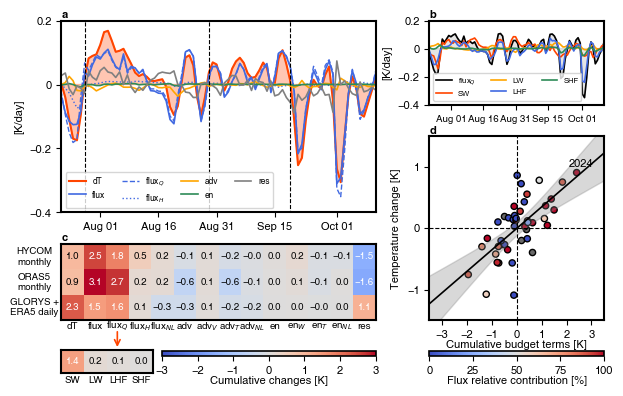

In [181]:
fig = plt.figure(figsize=(7, 4.5))
fig.subplots_adjust(hspace=0.5,wspace=0.22)
gs = GridSpec(4, 2, figure=fig,width_ratios=[1.8,1],height_ratios=[1.1,1,1,0.2])

ax0 = fig.add_subplot(gs[:2, 0])
ax0.plot(date_d,weight_mean(dt_prime_daily*mask_hightemp,dx,dy)*24*3600,color='orangered',lw=1.5,label='dT')
ax0.fill_between(date_d,np.zeros_like(weight_mean(dt_prime_daily*mask_hightemp,dx,dy)),weight_mean(dt_prime_daily*mask_hightemp,dx,dy)*24*3600,color='orangered',alpha=0.3)
ax0.plot(date_d,weight_mean((flux_Q_daily+flux_H_daily+flux_NL_daily)*mask_hightemp,dx,dy)*24*3600,c='royalblue',lw=1.2,label='flux')
ax0.plot(date_d,weight_mean((flux_Q_daily)*mask_hightemp,dx,dy)*24*3600,c='royalblue',ls='--',lw=1,label='flux$_Q$')
ax0.plot(date_d,weight_mean((flux_H_daily)*mask_hightemp,dx,dy)*24*3600,c='royalblue',ls=':',lw=1,label='flux$_H$')
ax0.plot(date_d,weight_mean((adv_pp_daily+adv_bp_daily+adv_pb_daily)*mask_hightemp,dx,dy)*24*3600,c='orange',lw=1.2,label='adv')
ax0.plot(date_d,weight_mean((en_pb_daily+en_bp_daily+en_pp_daily)*mask_hightemp,dx,dy)*24*3600,c='seagreen',lw=1.2,label='en')
ax0.plot(date_d,weight_mean((dt_prime_daily-flux_ALL_daily-adv_pp_daily-adv_bp_daily-adv_pb_daily-en_pb_daily-en_bp_daily-en_pp_daily)*mask_hightemp,dx,dy)*24*3600,c='grey',lw=1.2,label='res')

ax0.plot([date_d[208],date_d[208]],[-1,1],'k',ls='--',lw=0.8)
ax0.plot([date_d[240],date_d[240]],[-1,1],'k',ls='--',lw=0.8)
ax0.plot([date_d[261],date_d[261]],[-1,1],'k',ls='--',lw=0.8)

ax0.legend(loc=3,fontsize=6,ncols=4)
ax0.set_xlim(date_d[202],date_d[283])
ax0.set_ylim([-0.4,0.2])
ax0.set_yticks([-0.4,-0.2,0,0.2])
ax0.set_yticklabels(['−0.4','−0.2','0','0.2'],fontsize=8)
ax0.set_xticks([date_d[212],date_d[227],date_d[242],date_d[257],date_d[273]])
ax0.set_xticklabels(['Aug 01','Aug 16','Aug 31','Sep 15','Oct 01'],fontsize=8)
ax0.set_ylabel('[K/day]',fontsize=8)
ax0.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax1 = fig.add_subplot(gs[2, 0])
im = ax1.pcolormesh(p2024_high,vmax=3,vmin=-3,cmap='coolwarm')
ax1.set_xticks([])
ax1.set_yticks([])
diag_text=['dT','flux','flux$_Q$','flux$_H$','flux$_{NL}$','adv','adv$_V$','adv$_T$','adv$_{NL}$','en','en$_W$','en$_T$','en$_{NL}$','res']
for j in range(14):
    center_x = (2*j+1) / 2
    center_y = -0.25
    value = diag_text[j]
    text_color = 'black'
    ax1.text(center_x, center_y, diag_text[j],
                ha='center', va='center', color=text_color, fontsize=7)
ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)

name = ['GLORYS +\nERA5 daily','ORAS5\nmonthly','HYCOM\nmonthly']
for i in range(3):
    center_x = -1.2
    center_y = (2*i+1) / 2
    value = diag_text[j]
    text_color = 'black'
    ax1.text(center_x, center_y, name[i],rotation=0,
                ha='center', va='center', color=text_color, fontsize=7)

ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)

for i in range(3):
    for j in range(14):
        center_x = (2*j+1) / 2
        center_y = (2*i+1) / 2
        value = p2024_high[i, j]
        text_color = 'white' if np.abs(value) > 1 else 'black'
        if value<0:
            pre='−'
        else:
            pre=''
        ax1.text(center_x, center_y, pre+f'{np.abs(value):.1f}',
                 ha='center', va='center', color=text_color, fontsize=7)

inset_ax = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=(0.022,-0.6,0.29,0.3), bbox_transform=ax1.transAxes)
inset_ax.pcolormesh(qqq[None,:]*24*3600,vmax=3,vmin=-3,cmap='coolwarm')
inset_ax.set_xticks([])
inset_ax.set_yticks([])
for j in range(4):
    center_x = (2*j+1) / 2
    value = qqq[j]*24*3600
    text_color = 'white' if np.abs(value) > 1 else 'black'
    if value<0:
            pre='−'
    else:
        pre=''
    inset_ax.text(center_x,0.5, pre+f'{np.abs(value):.1f}',
                ha='center', va='center', color=text_color, fontsize=7)

diag_text1=['SW','LW','LHF','SHF']
for j in range(4):
    center_x = (2*j+1) / 2
    center_y = -0.3
    value = diag_text[j]
    text_color = 'black'
    inset_ax.text(center_x, center_y, diag_text1[j],
                ha='center', va='center', color=text_color, fontsize=7)
inset_ax.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(date_d,weight_mean((flux_Q_daily)*mask_hightemp,dx,dy)*24*3600,c='k',lw=1.2,label='flux$_Q$')
ax2.fill_between(date_d,np.zeros_like(weight_mean((flux_Q_daily)*mask_hightemp,dx,dy)),weight_mean((flux_Q_daily)*mask_hightemp,dx,dy)*24*3600,
                color='k',alpha=0.1)
ax2.plot(date_d,weight_mean((flux_SW_daily)*mask_hightemp,dx,dy)*24*3600,c='orangered',lw=1.2,label='SW')
ax2.plot(date_d,weight_mean((flux_LW_daily)*mask_hightemp,dx,dy)*24*3600,c='orange',lw=1.2,label='LW')
ax2.plot(date_d,weight_mean((flux_LHF_daily)*mask_hightemp,dx,dy)*24*3600,c='royalblue',lw=1.2,label='LHF')
ax2.plot(date_d,weight_mean((flux_SHF_daily)*mask_hightemp,dx,dy)*24*3600,c='seagreen',lw=1.2,label='SHF')
ax2.legend(loc=3,fontsize=5.5,ncols=3)
ax2.set_xlim(date_d[202],date_d[283])
ax2.set_ylim([-0.4,0.2])
ax2.set_yticks([-0.4,-0.2,0,0.2])
ax2.set_yticklabels(['−0.4','−0.2','0','0.2'],fontsize=8)
ax2.set_xticks([date_d[212],date_d[227],date_d[242],date_d[257],date_d[273]])
ax2.set_xticklabels(['Aug 01','Aug 16','Aug 31','Sep 15','Oct 01'],fontsize=7)
ax2.set_ylabel('[K/day]',fontsize=8)
ax2.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax3 = fig.add_subplot(gs[1:3, 1])
ax3.scatter(budget_high_s[np.isnan(diag_high_s)],dt_high_s[np.isnan(diag_high_s)],c='dimgrey',s=20,edgecolors='k')
cs = ax3.scatter(budget_high_s,dt_high_s,c=(diag_high_s)*100,s=20,cmap='coolwarm',vmin=0,vmax=100,edgecolors='k')
ax3.plot(budget_high_s_fit, dt_high_s_fit,'k',lw=1.2)
ax3.fill_between(budget_high_s_fit, dt_high_s_fit - ci, dt_high_s_fit + ci,alpha=0.3,color='grey')
ax3.plot([-8,8],[0,0],'k',lw=0.8,ls='--')
ax3.plot([0,0],[-8,8],'k',lw=0.8,ls='--')
ax3.set_xlim([-3.5,3.5])
ax3.set_ylim([-1.5,1.5])
ax3.set_xticks([-3,-2,-1,0,1,2,3],['−3','−2','−1','0','1','2','3'],fontsize=8)
ax3.set_yticks([-1,0,1],['−1','0','1'],fontsize=8)
ax3.set_ylabel('Temperature change [K]',fontsize=8)
ax3.set_xlabel('Cumulative budget terms [K]',fontsize=8,labelpad=0)
ax3.spines[['top','bottom','left','right']].set_linewidth(1.5)
ax3.text(budget_high_s[-1]-0.3,dt_high_s[-1]+0.1,'2024',fontsize=8)

cax = add_bottom_cax_big_right (ax1, ax1, pad=0.068, width=0.012, k=0.68)
cb =  fig.colorbar(im,cax=cax,orientation='horizontal')
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('Cumulative changes [K]',fontsize=8,labelpad=0)

cax = add_bottom_cax_big(ax3,ax3, pad=0.068, width=0.012)
cb =  fig.colorbar(cs,cax=cax,orientation='horizontal')
cb.set_ticks([0,25,50,75,100])
cb.set_ticklabels([0,25,50,75,100],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('Flux relative contribution [%]',fontsize=8,labelpad=0)

ax0.set_title('a',loc='left',fontsize=8,fontweight='bold',pad=2)
ax1.set_title('c',loc='left',fontsize=8,fontweight='bold',pad=2)
ax2.set_title('b',loc='left',fontsize=8,fontweight='bold',pad=2)
ax3.set_title('d',loc='left',fontsize=8,fontweight='bold',pad=2)

inset_ax1 = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=(0.20,-0.26,0.2,0.2), bbox_transform=ax1.transAxes)
inset_ax1.annotate(
    '',                         # 无文本
    xy=[0,0],                     # 终点
    xytext=[0,1],               # 起点
    arrowprops=dict(
        arrowstyle='->',        # 箭头样式
        color='orangered',
        lw=1.2,
        shrinkA=0, shrinkB=0    # 不收缩起点/终点
    )
)
inset_ax1.axis('off')
fig_format = 'pdf'
fig.savefig('./fig/Fig4.' + fig_format, format=fig_format, dpi = 300)

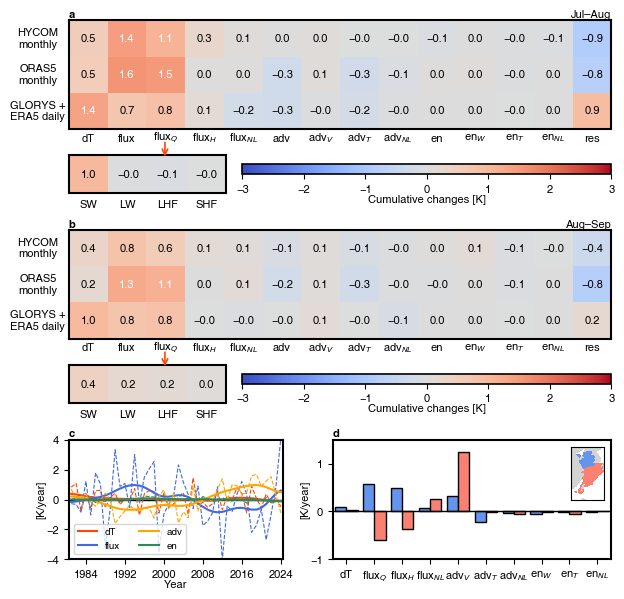

In [190]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.9)
gs = GridSpec(3, 2, figure=fig,height_ratios=[1,1,1.1],width_ratios=[1,1.3])

ax1 = fig.add_subplot(gs[0, :])
im = ax1.pcolormesh(p2024_high_8,vmax=3,vmin=-3,cmap='coolwarm')
ax1.set_xticks([])
ax1.set_yticks([])
diag_text=['dT','flux','flux$_Q$','flux$_H$','flux$_{NL}$','adv','adv$_V$','adv$_T$','adv$_{NL}$','en','en$_W$','en$_T$','en$_{NL}$','res']
for j in range(14):
    center_x = (2*j+1) / 2
    center_y = -0.25
    value = diag_text[j]
    text_color = 'black'
    ax1.text(center_x, center_y, diag_text[j],
                ha='center', va='center', color=text_color, fontsize=8)

name = ['GLORYS +\nERA5 daily','ORAS5\nmonthly','HYCOM\nmonthly']
for i in range(3):
    center_x = -0.8
    center_y = (2*i+1) / 2
    value = diag_text[j]
    text_color = 'black'
    ax1.text(center_x, center_y, name[i],rotation=0,
                ha='center', va='center', color=text_color, fontsize=8)

ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)

for i in range(3):
    for j in range(14):
        center_x = (2*j+1) / 2
        center_y = (2*i+1) / 2
        value = p2024_high_8[i, j]
        text_color = 'white' if np.abs(value) > 1 else 'black'
        if value<0:
            pre='−'
        else:
            pre=''
        ax1.text(center_x, center_y, pre+f'{np.abs(value):.1f}',
                 ha='center', va='center', color=text_color, fontsize=8)

inset_ax = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=(0.013,-0.53,0.29,0.35), bbox_transform=ax1.transAxes)
inset_ax.pcolormesh(qqq_8[None,:]*24*3600,vmax=3,vmin=-3,cmap='coolwarm')
inset_ax.set_xticks([])
inset_ax.set_yticks([])
for j in range(4):
    center_x = (2*j+1) / 2
    value = qqq_8[j]*24*3600
    text_color = 'white' if np.abs(value) > 1 else 'black'
    if value<0:
            pre='−'
    else:
        pre=''
    inset_ax.text(center_x,0.5, pre+f'{np.abs(value):.1f}',
                ha='center', va='center', color=text_color, fontsize=8)

diag_text1=['SW','LW','LHF','SHF']
for j in range(4):
    center_x = (2*j+1) / 2
    center_y = -0.3
    value = diag_text[j]
    text_color = 'black'
    inset_ax.text(center_x, center_y, diag_text1[j],
                ha='center', va='center', color=text_color, fontsize=8)
inset_ax.spines[['top','bottom','left','right']].set_linewidth(1.5)

cax = add_bottom_cax_big_right (ax1, ax1, pad=0.05, width=0.015, k=0.68)
cb =  fig.colorbar(im,cax=cax,orientation='horizontal')
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('Cumulative changes [K]',fontsize=8,labelpad=0)

ax1.set_title('a',loc='left',fontsize=8,fontweight='bold',pad=2)
ax1.set_title('Jul\u2013Aug',loc='right',fontsize=8,pad=2)

inset_ax1 = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=(0.19,-0.19,0.2,0.13), bbox_transform=ax1.transAxes)
inset_ax1.annotate(
    '',                         # 无文本
    xy=[0,0],                     # 终点
    xytext=[0,1],               # 起点
    arrowprops=dict(
        arrowstyle='->',        # 箭头样式
        color='orangered',
        lw=1.2,
        shrinkA=0, shrinkB=0    # 不收缩起点/终点
    )
)
inset_ax1.axis('off')


ax2 = fig.add_subplot(gs[1, :])
im = ax2.pcolormesh(p2024_high_9,vmax=3,vmin=-3,cmap='coolwarm')
ax2.set_xticks([])
ax2.set_yticks([])

for j in range(14):
    center_x = (2*j+1) / 2
    center_y = -0.25
    value = diag_text[j]
    text_color = 'black'
    ax2.text(center_x, center_y, diag_text[j],
                ha='center', va='center', color=text_color, fontsize=8)
ax2.spines[['top','bottom','left','right']].set_linewidth(1.5)

for i in range(3):
    center_x = -0.8
    center_y = (2*i+1) / 2
    value = diag_text[j]
    text_color = 'black'
    ax2.text(center_x, center_y, name[i],rotation=0,
                ha='center', va='center', color=text_color, fontsize=8)

for i in range(3):
    for j in range(14):
        center_x = (2*j+1) / 2
        center_y = (2*i+1) / 2
        value = p2024_high_9[i, j]
        text_color = 'white' if np.abs(value) > 1 else 'black'
        if value<0:
            pre='−'
        else:
            pre=''
        ax2.text(center_x, center_y, pre+f'{np.abs(value):.1f}',
                 ha='center', va='center', color=text_color, fontsize=8)

inset_ax11 = inset_axes(ax2, width="100%", height="100%", bbox_to_anchor=(0.013,-0.53,0.29,0.35), bbox_transform=ax2.transAxes)
inset_ax11.pcolormesh(qqq_9[None,:]*24*3600,vmax=3,vmin=-3,cmap='coolwarm')
inset_ax11.set_xticks([])
inset_ax11.set_yticks([])
for j in range(4):
    center_x = (2*j+1) / 2
    value = qqq_9[j]*24*3600
    text_color = 'white' if np.abs(value) > 1 else 'black'
    if value<0:
        pre='−'
    else:
        pre=''
    inset_ax11.text(center_x,0.5, pre+f'{np.abs(value):.1f}',
                ha='center', va='center', color=text_color, fontsize=8)

for j in range(4):
    center_x = (2*j+1) / 2
    center_y = -0.3
    value = diag_text[j]
    text_color = 'black'
    inset_ax11.text(center_x, center_y, diag_text1[j],
                ha='center', va='center', color=text_color, fontsize=8)
inset_ax11.spines[['top','bottom','left','right']].set_linewidth(1.5)

cax = add_bottom_cax_big_right (ax2, ax2, pad=0.05, width=0.015, k=0.68)
cb =  fig.colorbar(im,cax=cax,orientation='horizontal')
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('Cumulative changes [K]',fontsize=8,labelpad=0)

ax2.set_title('b',loc='left',fontsize=8,fontweight='bold',pad=2)
ax2.set_title('Aug\u2013Sep',loc='right',fontsize=8,pad=2)

inset_ax2 = inset_axes(ax1, width="100%", height="100%", bbox_to_anchor=(0.19,-0.19,0.2,0.13), bbox_transform=ax2.transAxes)
inset_ax2.annotate(
    '',                         # 无文本
    xy=[0,0],                     # 终点
    xytext=[0,1],               # 起点
    arrowprops=dict(
        arrowstyle='->',        # 箭头样式
        color='orangered',
        lw=1.2,
        shrinkA=0, shrinkB=0    # 不收缩起点/终点
    )
)
inset_ax2.axis('off')

ax3 = fig.add_subplot(gs[2, 0])
ax3.plot([1980,2025],[0,0],'k',lw=1)
ax3.plot(np.arange(1981,2025),weight_mean(sel_year(dt_prime_oras5,1,12)*mask_hightemp,dx,dy)*86400*365,'orangered',ls='--',lw=0.8)
ax3.plot(np.arange(1981,2025),gaussian_filter(weight_mean(sel_year(dt_prime_oras5,1,12)*mask_hightemp,dx,dy),4/1.414)*86400*365,'orangered',lw=1.5,label='dT')
ax3.plot(np.arange(1981,2025),weight_mean(sel_year(flux_Q_oras5+flux_H_oras5+flux_NL_oras5,1,12)*mask_hightemp,dx,dy)*86400*365,'royalblue',ls='--',lw=0.8)
ax3.plot(np.arange(1981,2025),gaussian_filter(weight_mean(sel_year(flux_Q_oras5+flux_H_oras5+flux_NL_oras5,1,12)*mask_hightemp,dx,dy),4/1.414)*86400*365,'royalblue',lw=1.5,label='flux')
ax3.plot(np.arange(1981,2025),weight_mean(sel_year(adv_pp_oras5+adv_bp_oras5+adv_pb_oras5,1,12)*mask_hightemp,dx,dy)*86400*365,'orange',ls='--',lw=0.8)
ax3.plot(np.arange(1981,2025),gaussian_filter(weight_mean(sel_year(adv_pp_oras5+adv_bp_oras5+adv_pb_oras5,1,12)*mask_hightemp,dx,dy),4/1.414)*86400*365,'orange',lw=1.5,label='adv')
ax3.plot(np.arange(1981,2025),weight_mean(sel_year((en_pb_oras5+en_bp_oras5+en_pp_oras5),1,12)*mask_hightemp,dx,dy)*86400*365,'seagreen',ls='--',lw=0.8)
ax3.plot(np.arange(1981,2025),gaussian_filter(weight_mean(sel_year(en_pb_oras5+en_bp_oras5+en_pp_oras5,1,12)*mask_hightemp,dx,dy),4/1.414)*86400*365,'seagreen',lw=1.5,label='en')
ax3.set_xlim([1980.5,2024.5])
ax3.set_ylim([-4,4])
ax3.set_yticks([-4,-2,0,2,4],['−4','−2','0','2','4'],fontsize=8)
ax3.set_xticks([1984,1992,2000,2008,2016,2024],[1984,1992,2000,2008,2016,2024],fontsize=8)
ax3.set_xlabel('Year',fontsize=8,labelpad=0)
ax3.set_ylabel("[K/year]",fontsize=8,labelpad=0)
ax3.legend(loc='lower left',ncol=2,fontsize=7)
ax3.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax4 = fig.add_subplot(gs[2, 1])
ax4.plot([-1,10],[0,0],'k',lw=1)
# ax4.bar(np.array([0,1,2,3,4,5,6,7,8,9])-0.25,(np.array(diag_oras5_near) - np.array(diag_oras5_clim))*86400*365,width=0.25,color='#E76F51', edgecolor='black')
ax4.bar(np.array([0,1,2,3,4,5,6,7,8,9])-0.2,(np.array(diag_oras5_near_YS) - np.array(diag_oras5_clim_YS))*86400*365,width=0.4,color='cornflowerblue', edgecolor='black')
ax4.bar(np.array([0,1,2,3,4,5,6,7,8,9])+0.2,(np.array(diag_oras5_near_ECS) - np.array(diag_oras5_clim_ECS))*86400*365,width=0.4,color='salmon', edgecolor='black')
ax4.set_xticks(np.array([0,1,2,3,4,5,6,7,8,9]))
ax4.set_xticklabels(['dT','flux$_Q$','flux$_H$','flux$_{NL}$','adv$_V$','adv$_T$','adv$_{NL}$','en$_W$','en$_T$','en$_{NL}$'],fontsize=8)
ax4.set_xlim([-0.5,9.5])
ax4.set_ylim([-1,1.5])
ax4.set_yticks([-1,0,1],['−1','0','1'],fontsize=8)
ax4.set_ylabel("[K/year]",fontsize=8,labelpad=0)
# ax4.legend(loc='upper right',ncol=1,fontsize=7)
ax4.spines[['top','bottom','left','right']].set_linewidth(1.5)
inset_ax = inset_axes(ax4, width="12%", height="45%", loc="upper right")
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_YS[70:,45:],colors='cornflowerblue')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_ECS[70:,45:],colors='salmon')
inset_ax.set_xticks([])
inset_ax.set_yticks([])

ax3.set_title('c',loc='left',fontsize=8,fontweight='bold',pad=2)
ax4.set_title('d',loc='left',fontsize=8,fontweight='bold',pad=2)
fig.savefig('./fig/FigS6.' + fig_format, format=fig_format, dpi = 300)